In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from geopy.geocoders import Nominatim
from functools import partial

In [3]:
import pycountry
import pycountry_convert as pc

In [4]:
import plotly.express as px

# Data load

In [5]:
data = pd.read_csv('ramen-ratings.csv')
data.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


# Preprocessing

In [6]:
data.shape

(2580, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 80.7+ KB


Two missing values in column 'Style'.

In [8]:
data.dtypes

Review #     int64
Brand       object
Variety     object
Style       object
Country     object
Stars       object
Top Ten     object
dtype: object

In [9]:
data[['Brand', 'Variety', 'Style', 'Country', 'Top Ten']].nunique()

Brand       355
Variety    2413
Style         7
Country      38
Top Ten      38
dtype: int64

In [10]:
# To lower case
data.Brand = data.Brand.str.lower() 
data.Variety = data.Variety.str.lower()
data.Style = data.Style.str.lower()
data.Country = data.Country.str.lower()

### Stars

In [11]:
data.Stars.sort_values().unique()

array(['0', '0.1', '0.25', '0.5', '0.75', '0.9', '1', '1.1', '1.25',
       '1.5', '1.75', '1.8', '2', '2.1', '2.125', '2.25', '2.3', '2.5',
       '2.75', '2.8', '2.85', '2.9', '3', '3.0', '3.00', '3.1', '3.125',
       '3.2', '3.25', '3.3', '3.4', '3.5', '3.50', '3.6', '3.65', '3.7',
       '3.75', '3.8', '4', '4.0', '4.00', '4.125', '4.25', '4.3', '4.5',
       '4.50', '4.75', '5', '5.0', '5.00', 'Unrated'], dtype=object)

In [12]:
print('Procentage of `Unrated` ramens : {}%'.format(round(np.sum(data.Stars.isin(['Unrated']))*100/len(data),2)))

Procentage of `Unrated` ramens : 0.12%


In [13]:
# Setting all ratings to float and filling with zeros if 'Unrated' or missed value
data['Stars'] = pd.to_numeric(data.Stars, errors='coerce')
data['Stars'] = data.Stars.fillna(0)
data['Stars'] = data.Stars.astype('float')

# Rounding ratings to equal amount of decimal places
data['Stars'] = np.around(data.Stars,decimals=1)

### Style

In [14]:
data.Style.unique()

array(['cup', 'pack', 'tray', 'bowl', 'box', 'can', 'bar', nan],
      dtype=object)

In [15]:
data[data.Style.isnull()]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
2152,428,kamfen,e menm chicken,NaN,china,3.8,NaN
2442,138,unif,100 furong shrimp,NaN,taiwan,3.0,NaN


In [16]:
# Filling 2 missing ramen styles after online check
data['Style'] = np.where(data.Style.isnull(), 'pack', data.Style)

### Country

In [17]:
data.Country.unique()

array(['japan', 'taiwan', 'usa', 'india', 'south korea', 'singapore',
       'thailand', 'hong kong', 'vietnam', 'ghana', 'malaysia',
       'indonesia', 'china', 'nigeria', 'germany', 'hungary', 'mexico',
       'fiji', 'australia', 'pakistan', 'bangladesh', 'canada', 'nepal',
       'brazil', 'uk', 'myanmar', 'netherlands', 'united states',
       'cambodia', 'finland', 'sarawak', 'philippines', 'sweden',
       'colombia', 'estonia', 'holland', 'poland', 'dubai'], dtype=object)

In [18]:
geolocator = Nominatim(timeout=20)
geocode = partial(geolocator.geocode, language="en")

In [19]:
# Unify country names
countries = list(map(lambda c: geocode(c).address.split(', ')[-1], list(data.Country.unique())))

fix_dict = {k:v for k,v in zip(list(data.Country.unique()), countries) if k != v}

In [20]:
data.Country.replace(fix_dict,inplace=True)

In [21]:
data.Country.unique()

array(['Japan', 'Taiwan', 'United States', 'India', 'South Korea',
       'Singapore', 'Thailand', 'China', 'Vietnam', 'Ghana', 'Malaysia',
       'Indonesia', 'Nigeria', 'Germany', 'Hungary', 'Mexico', 'Fiji',
       'Australia', 'Pakistan', 'Bangladesh', 'Canada', 'Nepal', 'Brazil',
       'United Kingdom', 'Myanmar', 'Netherlands', 'Cambodia', 'Finland',
       'Philippines', 'Sweden', 'Colombia', 'Estonia', 'Poland',
       'United Arab Emirates'], dtype=object)

In [22]:
data.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,new touch,t's restaurant tantanmen,cup,Japan,3.8,NaN
1,2579,just way,noodles spicy hot sesame spicy hot sesame guan...,pack,Taiwan,1.0,NaN
2,2578,nissin,cup noodles chicken vegetable,cup,United States,2.2,NaN
3,2577,wei lih,gge ramen snack tomato flavor,pack,Taiwan,2.8,NaN
4,2576,ching's secret,singapore curry,pack,India,3.8,NaN


# Data Analysis

## Ratings

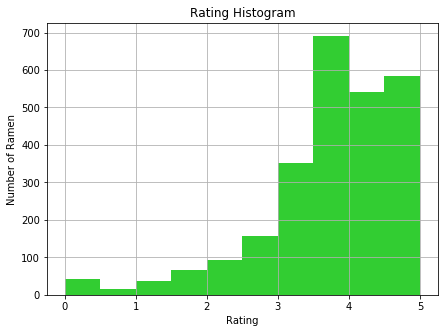

In [23]:
rat = plt.subplots(figsize=(7, 5))
rat = data.Stars.hist(color='limegreen')
plt.xlabel('Rating')
plt.ylabel('Number of Ramen')
plt.title('Rating Histogram')
plt.show()

In [24]:
data['Stars'].median()

3.8

In [25]:
round(data['Stars'].mean(),2)


3.65

#### Ramen has average rating of 3.7 star

## Style

#### Most eaten Style of Ramen

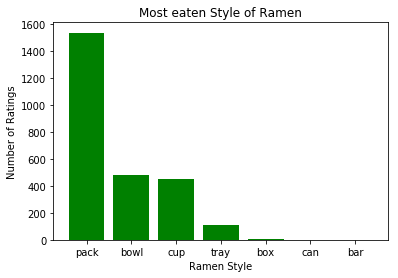

In [26]:
styles = dict(data['Style'].value_counts())
plt.bar(range(len(styles)), list(styles.values()), align='center', color='green')
plt.xticks(range(len(styles)), list(styles.keys()))
plt.ylabel('Number of Ratings')
plt.xlabel('Ramen Style')
plt.title('Most eaten Style of Ramen')
plt.show()

### Ratings in each ramen style

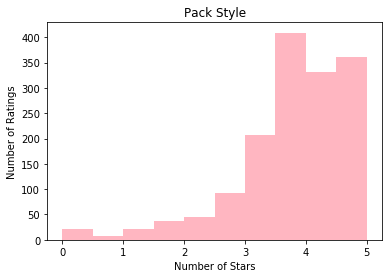

In [27]:
pack_freq = data['Stars'].loc[data['Style'] == 'pack'].astype(float)
pack_freq.plot(kind='hist',color='lightpink')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Pack Style')
plt.show()

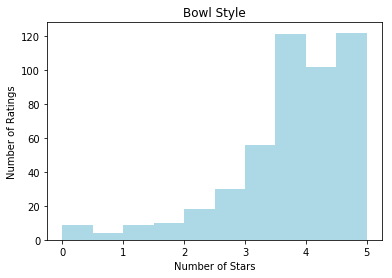

In [28]:
bowl_freq = data['Stars'].loc[data['Style'] == 'bowl'].astype(float)
bowl_freq.plot(kind='hist',color='lightblue')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Bowl Style')
plt.show()

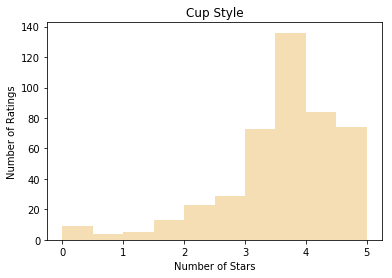

In [29]:
cup_freq = data['Stars'].loc[data['Style'] == 'cup'].astype(float)
cup_freq.plot(kind='hist',color='wheat')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
_ = plt.title('Cup Style')
plt.show()

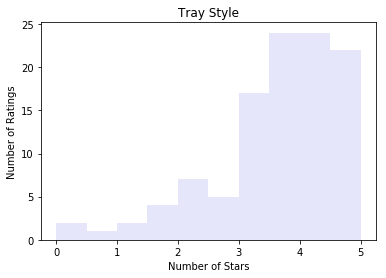

In [30]:
tray_freq = data['Stars'].loc[data['Style'] == 'tray'].astype(float)
tray_freq.plot(kind='hist',color='lavender')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Tray Style')
plt.show()

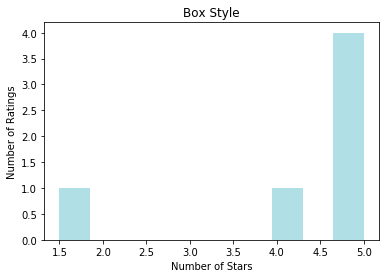

In [31]:
box_freq = data['Stars'].loc[data['Style'] == 'box'].astype(float)
box_freq.plot(kind='hist',color='powderblue')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Box Style')
plt.show()

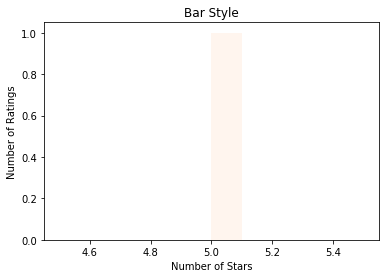

In [32]:
bar_freq = data['Stars'].loc[data['Style'] == 'bar'].astype(float)
bar_freq.plot(kind='hist',color='seashell')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Bar Style')
plt.show()

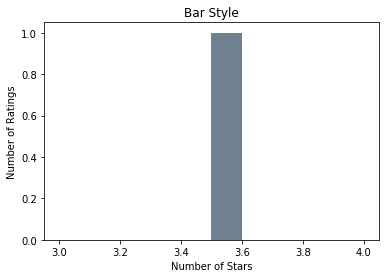

In [33]:
can_freq = data['Stars'].loc[data['Style'] == 'can'].astype(float)
can_freq.plot(kind='hist',color='slategray')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Bar Style')
plt.show()

## Country

#### Frequency of stars given in each *country*

In [34]:
c_dicts = []
c_names = []
countries = data.Country.unique()
for c in countries:
    c_dicts.append(dict(data.Style.loc[data.Country == c].value_counts()))
    c_names.append(c)

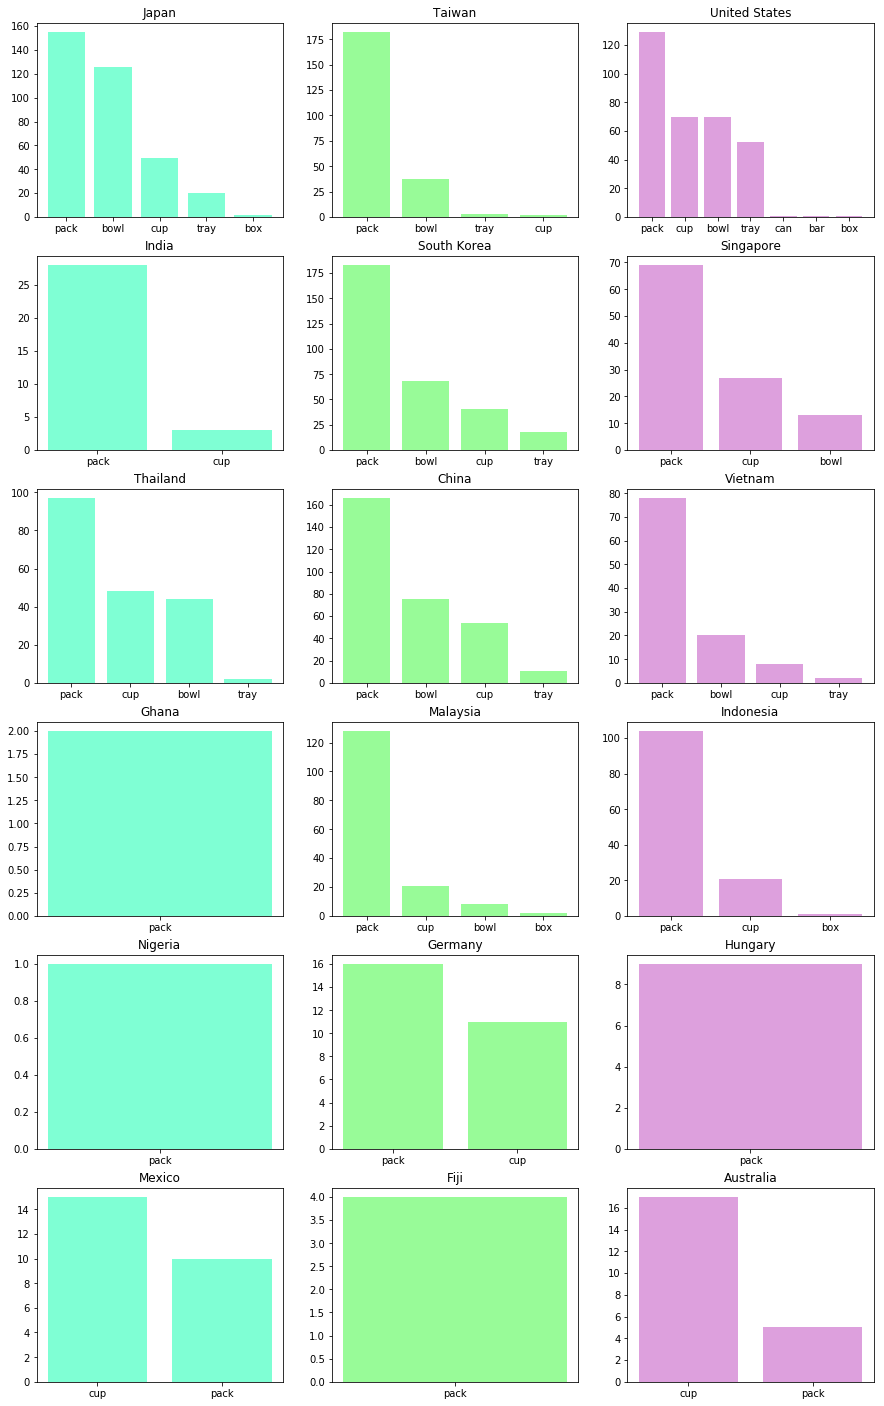

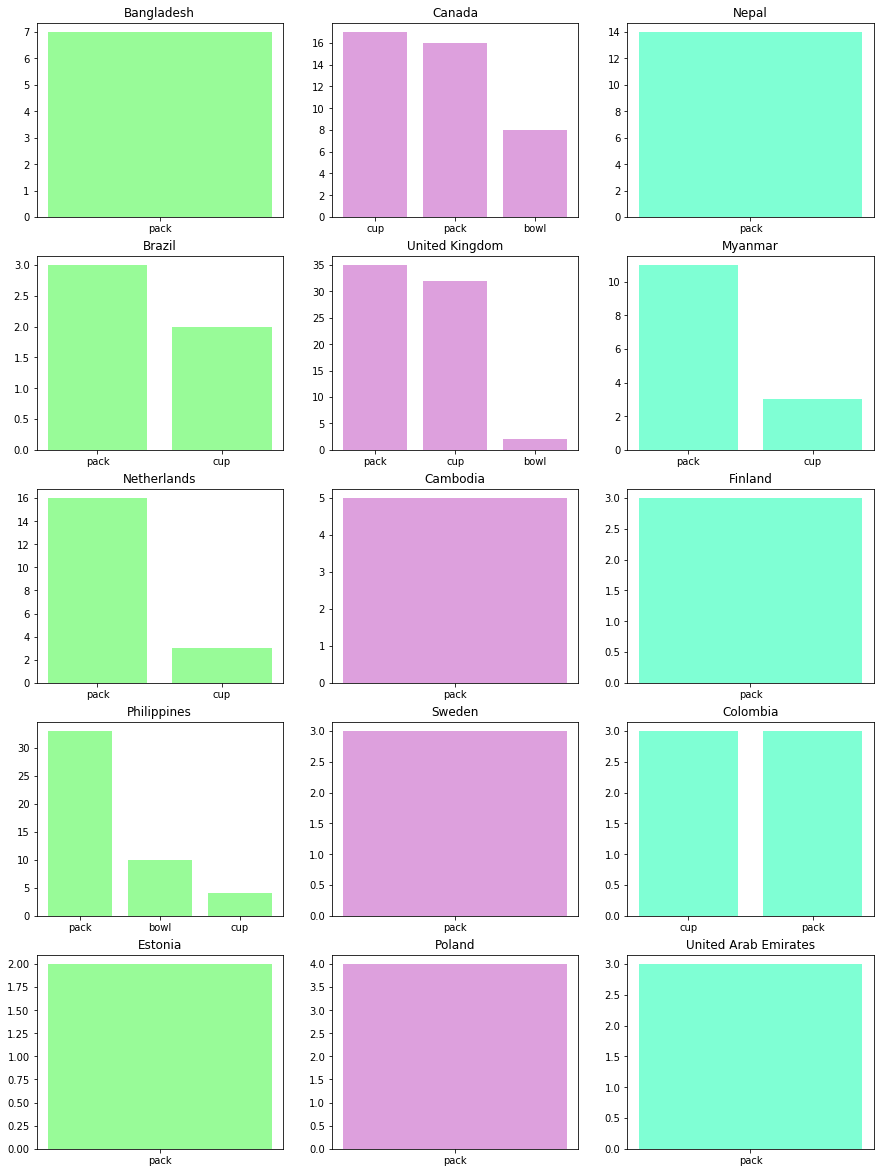

In [35]:
def get_x(country_dict):
    x = []
    for key,value in country_dict.items():
        x.append(key)
    return x

def get_y(country_dict):
    y = []
    for key,value in country_dict.items():
        y.append(value)
    return y

colors = ['aquamarine', 'palegreen', 'plum']

plt.figure(figsize=(15,25), facecolor='white')
plot_number = 1
for i in range(18):
    ax = plt.subplot(6, 3, plot_number)
    ax.bar(get_x(c_dicts[i]), get_y(c_dicts[i]), color=colors[i%3])
    ax.set_title(c_names[i])
    plot_number = plot_number + 1

plt.figure(figsize=(15,25), facecolor='white')
plot_number = 1
for i in range(19,len(data.Country.unique())):
    ax = plt.subplot(6, 3, plot_number)
    ax.bar(get_x(c_dicts[i]), get_y(c_dicts[i]), color=colors[i%3])
    ax.set_title(c_names[i])
    plot_number = plot_number + 1

#### Number of participants in each *country*

In [36]:
country_counts = dict(data.Country.value_counts())
countries = get_x(country_counts)
counts = get_y(country_counts)

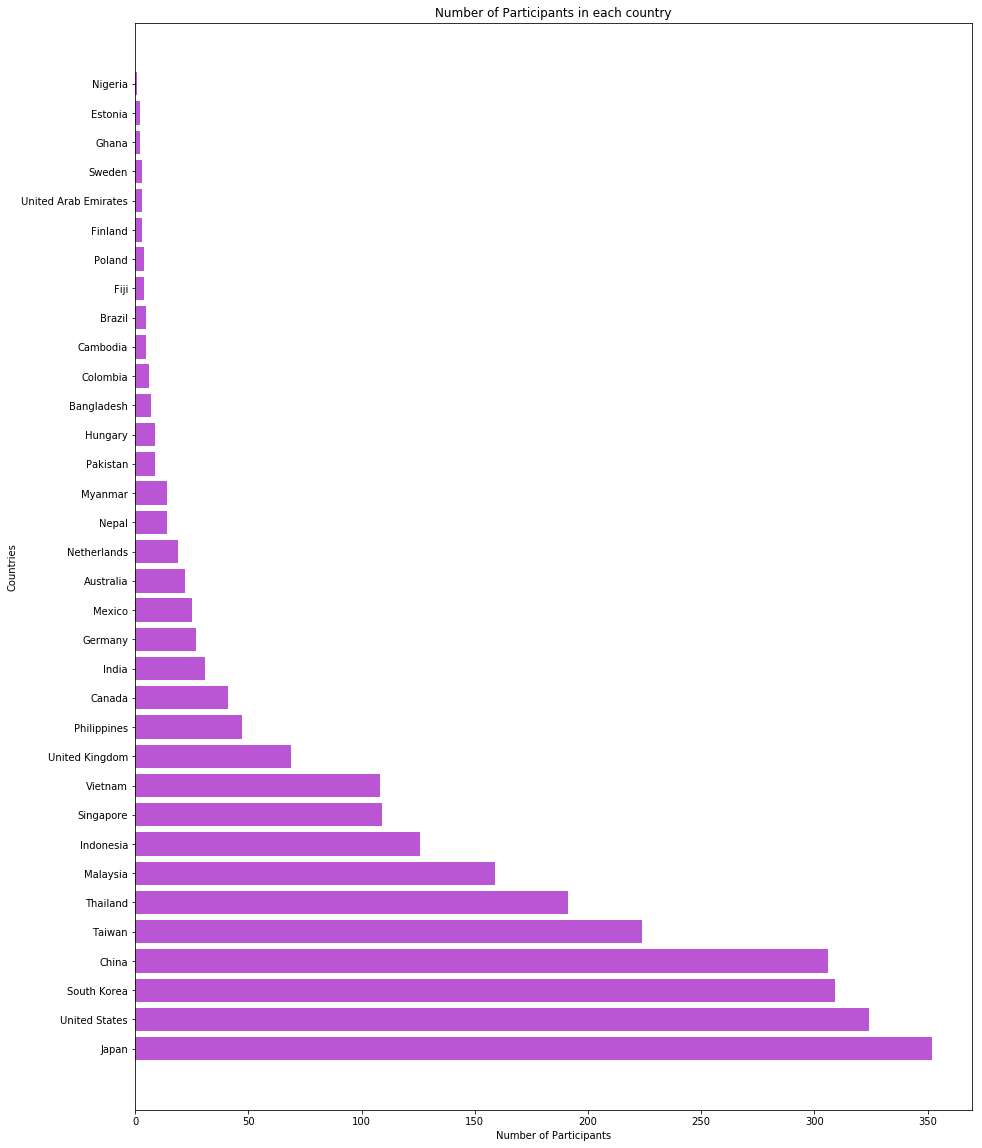

In [37]:
plt.figure(figsize=(15, 20))
plt.barh(countries,counts, color='mediumorchid')
plt.xlabel('Number of Participants')
plt.ylabel('Countries')
_ = plt.title('Number of Participants in each country')


## Brands

#### Top 10 best *Brands*

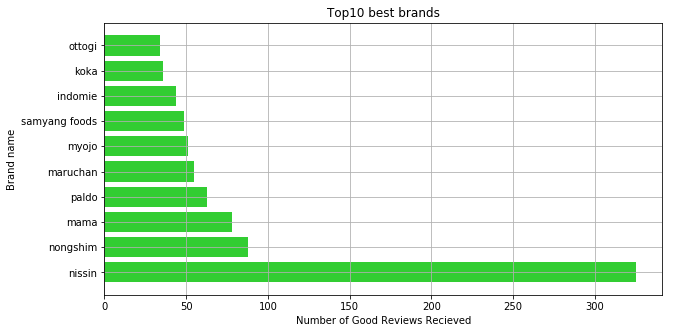

In [38]:
best_brands = dict(data.Brand.loc[data.Stars.astype(float) > 3.0].value_counts())
brand_names = list(best_brands.keys())
brand_apperance_count = list(best_brands.values())
plt.figure(figsize=(10, 5))
plt.barh(brand_names[:10],brand_apperance_count[:10], color='limegreen')
plt.xlabel('Number of Good Reviews Recieved')
plt.ylabel('Brand name')
plt.grid(True)
_ = plt.title('Top10 best brands')

#### Top 10 worst *Brands*

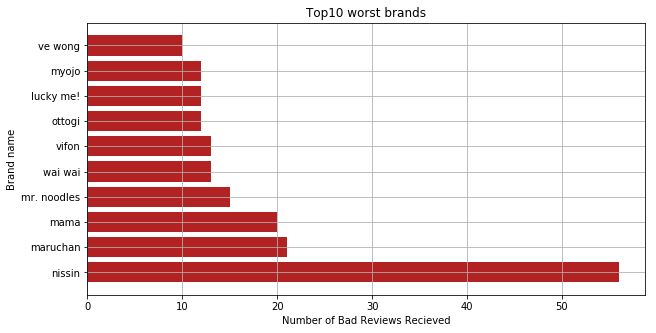

In [39]:
worst_brands = dict(data.Brand.loc[data.Stars.astype(float) <= 3.0].value_counts())
brand_names = list(worst_brands.keys())
brand_apperance_count = list(worst_brands.values())
plt.figure(figsize=(10, 5))
plt.barh(brand_names[:10],brand_apperance_count[:10], color='firebrick')
plt.xlabel('Number of Bad Reviews Recieved')
plt.ylabel('Brand name')
plt.grid(True)
_ = plt.title('Top10 worst brands')

#### Procentage of good and bad ramen

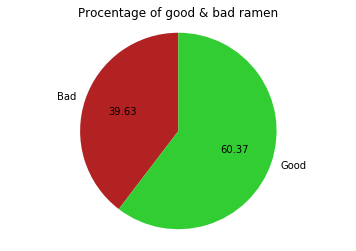

In [40]:
x = [len(data.Brand.loc[data.Stars.astype(float) <= 3.0].value_counts()),len(data.Brand.loc[data.Stars.astype(float) > 3.0].value_counts())]
plt.pie(x, labels=['Bad', 'Good'], autopct='%1.2f', startangle=90, colors=['firebrick','limegreen'])
plt.axis('equal')
_ = plt.title('Procentage of good & bad ramen')

#### Number of Bad and Good ratings in each serving style

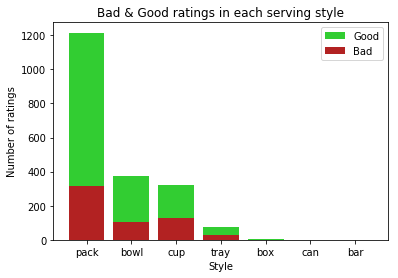

In [41]:
ax = plt.subplot(111)
good = ax.bar(get_x(data.Style.loc[data.Stars.astype(float) > 3.0].value_counts()),get_y(data.Style.loc[data.Stars.astype(float) > 3.0].value_counts()), color="limegreen")
bad = ax.bar(get_x(data.Style.loc[data.Stars.astype(float) <= 3.0].value_counts()),get_y(data.Style.loc[data.Stars.astype(float) <= 3.0].value_counts()),color="firebrick")
ax.legend((good, bad), ('Good', 'Bad'))
plt.xlabel('Style')
plt.ylabel('Number of ratings')
plt.title('Bad & Good ratings in each serving style')
plt.show()

#### Number of brands serving ramen in specyfic style

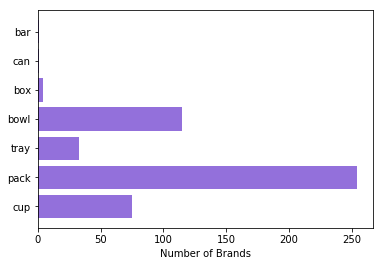

In [42]:
choices = {style: len(data.Brand.loc[data.Style == style].unique()) for style in data.Style.unique()}

plt.barh(get_x(choices),get_y(choices),color='mediumpurple')
plt.xlabel('Number of Brands')
plt.show()

## World map

In [43]:
world_df = pd.DataFrame()
world_df['Country'] = data.Country.sort_values().unique()
world_df['Style'] = pd.Series(map(lambda x: data[data.Country.isin([x])].groupby('Style').Stars.mean().sort_values(ascending=False).idxmax(), data.Country.sort_values().unique()))
world_df['Avg rating'] = pd.Series(map(lambda x: round(data[data.Country.isin([x])].groupby('Style').Stars.mean().sort_values(ascending=False).max(),1), data.Country.sort_values().unique()))
world_df['Popular style'] = pd.Series(map(lambda x : data.Style.where(data.Country == x).value_counts().idxmax(),data.sort_values(by='Country').Country.unique()))
world_df['ISO'] = pd.Series(map(lambda x: pc.country_name_to_country_alpha3(x),data.Country.sort_values().unique()))
world_df['Continent'] = pd.Series(map(lambda x: pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(x))),data.Country.sort_values().unique()))

In [44]:

fig = px.choropleth(world_df, locations="ISO", color="Style", hover_name='Country',hover_data=['Style','Avg rating', 'Popular style'],projection="natural earth",)
fig.update_layout(title_text='Highest rated ramen style of the world')
fig.show()